In [2]:
#This is the script which generates the Roche's mesh for DI Her eclipsing eccentric binary.
#The orbital and physical parameters of DI Her were adopted after Albrecht et al. (2009).
#Tested with phoebe version 2.4.5

#------------------------------------------------------------------------
# MODULES
#------------------------------------------------------------------------
import phoebe
import numpy as np
from phoebe import u
import matplotlib.pyplot as plt

In [3]:
#------------------------------------------------------------------------
# INITIALIZATION OF LOGGER AND BINARY SYSTEM
#------------------------------------------------------------------------
logger = phoebe.logger(clevel='error',flevel='warning',filename='DI-Her.log')
b      = phoebe.default_binary()

#------------------------------------------------------------------------
# PARAMETERS OF THE SYSTEM
#------------------------------------------------------------------------
P  = 10.550164 #orbital period in days
T0 = 2442233.3481 #time of periastron passage in HJD

b.set_value('period', component='binary', value=P*u.d)
b.set_value('ecc', component='binary', value=0.489)
b.set_value('per0', component='binary', value=330.2*u.deg)
b.set_value('incl', component='binary', value=89.3*u.deg)
b.set_value('t0_supconj', component='binary', value=T0*u.d)
b.set_value('vgamma',value=9.1*u.km/u.s)

#------------------------------------------------------------------------
# PHYSICAL PARAMETERS OF THE COMPONENTS
#------------------------------------------------------------------------
b.set_value('teff', component='primary', value=17300*u.K)
b.set_value('teff', component='secondary', value=15400*u.K)

b.set_value('requiv', component='primary', value=2.68*u.solRad)
b.set_value('requiv', component='secondary', value=2.48*u.solRad)

b.set_value('gravb_bol', component='primary', value=1.0)
b.set_value('gravb_bol', component='secondary', value=1.0)

b.set_value('irrad_frac_refl_bol', component='primary', value=1.0)
b.set_value('irrad_frac_refl_bol', component='secondary', value=1.0)

#Synchronicity parameters have to be calculated from vsini for both components
vsini_p = 109.0                              #km/s
vsini_s = 117.0                              #km/s
sini    = np.sin(89.3*np.pi/180.0)
vp, vs  = vsini_p/sini, vsini_s/sini         #km/s
R_sun   = 695700000                          #m
Prot_p  = 2*np.pi*2.68*R_sun/(vp*1000)/86400 #d
Prot_s  = 2*np.pi*2.48*R_sun/(vs*1000)/86400 #d

b.set_value('syncpar', component='primary', value=P/Prot_p)
b.set_value('syncpar', component='secondary', value=P/Prot_s)

b.flip_constraint('mass@primary', solve_for='sma@binary')
b.set_value('mass', component='primary', value=5.1*u.solMass)
b.flip_constraint('mass@secondary', solve_for='q')
b.set_value('mass', component='secondary', value=4.4*u.solMass)

b.set_value('pitch', component='primary', value=-27.3*u.deg)
b.set_value('yaw', component='primary', value=72.0*u.deg)
b.set_value('pitch', component='secondary', value=10.7*u.deg)
b.set_value('yaw', component='secondary', value=-84.0*u.deg)

In [4]:
#------------------------------------------------------------------------
# NUMBER OF TRIANGLES
#------------------------------------------------------------------------
b['ntriangles@primary']   = 2500
b['ntriangles@secondary'] = 2500

#------------------------------------------------------------------------
# TIME GRID
#------------------------------------------------------------------------
phases = np.linspace(-0.07,0.07,25) #only 25 moments of time in the given range of orbital phases, just for the test
times  = b.to_times(phases)

#------------------------------------------------------------------------
# ATMOSPHERIC MODELS
#------------------------------------------------------------------------
b.set_value('atm',component='primary',value='ck2004')
b.set_value('atm',component='secondary',value='ck2004')
b.set_value('abun',component='primary',value=0.0)
b.set_value('abun',component='secondary',value=0.0)

#------------------------------------------------------------------------
# DATASETS TO COMPUTE
#------------------------------------------------------------------------
b.add_dataset('mesh',compute_times=times,dataset='bigmesh',coordinates='xyz',columns=['us','vs','ws','vws','areas','loggs','teffs','mus','visibilities'])

#Phoebe provides a lot of information for each surface element, I have extracted only fraction of them
#as they are necessary to integrate the composite spectrum:
#us,vs,ws – the positions of elements in plane of the sky [R_sun], u and v are co-planar with the sky and w is perpendicular to the sky
#vws – the radial velocities of each element [km/s]
#areas, loggs, teffs, mus – self-explanatory
#visibilities – their values indicate if the specific element is visible for an observer

#------------------------------------------------------------------------
# RUNNING COMPUTE
#------------------------------------------------------------------------
b.run_compute(irrad_method='horvat',distortion_method='roche',ltte=False,rv_method='flux-weighted',rv_grav=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  6.25it/s]


<ParameterSet: 553 parameters | components: primary, secondary>

In [4]:
#animation of DI Her + distribution of radial velocities and teffs during periastron passage
#just for check/fun :)
# ---
# b['bigmesh@latest@model'].plot(fc='vws', ec='None', fclim=[-200,200], exclude_back=True, fcmap='seismic',axpos=211)
# b['bigmesh@latest@model'].plot(fc='teffs', ec='None', fclim=[17100,17500], exclude_back=True, fcmap='plasma',axpos=212)
# fig = plt.figure(figsize=(8,9),dpi=200)
# b.savefig('DI_Her-vrad+teff.mp4', fig=fig, tight_layouot=True, draw_sidebars=True, animate=True, save_kwargs={'writer': 'ffmpeg'})

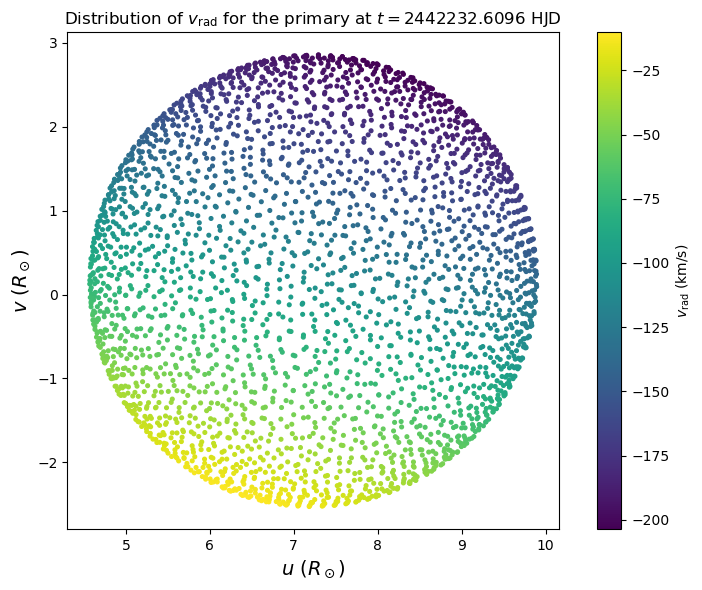

In [10]:
#------------------------------------------------------------------------
# ACCESSING VALUES FROM MESH FOR THE SPECIFIC MOMENT IN TIME
#------------------------------------------------------------------------
time = times[0]
U    = b.get_parameter(qualifier='us',component='primary',dataset='bigmesh',kind='mesh',time=time).value
V    = b.get_parameter(qualifier='vs',component='primary',dataset='bigmesh',kind='mesh',time=time).value
VW   = b.get_parameter(qualifier='vws',component='primary',dataset='bigmesh',kind='mesh',time=time).value

#example plot of the radial velocities of centers of triangular surface elements for the primary component
#just to show/check that everything works fine and smoothly :)
plt.close()
plt.figure(figsize=(8,6))
plt.gca().set_aspect('equal')
plt.scatter(U,V,marker='o',c=VW,s=7)
plt.xlabel(r'$u$ ($R_\odot$)',fontsize=14)
plt.ylabel(r'$v$ ($R_\odot$)',fontsize=14)
plt.title(r'Distribution of $v_{\rm rad}$ for the primary at $t=$'+str(np.around(time,4))+' HJD',fontsize=12)
plt.colorbar(label=r'$v_{\rm rad}$ (km/s)')
plt.tight_layout()
plt.show()

In [12]:
print(b.get_parameter(qualifier='columns').choices)

['volume', 'xs', 'ys', 'zs', 'vxs', 'vys', 'vzs', 'nxs', 'nys', 'nzs', 'us', 'vs', 'ws', 'vus', 'vvs', 'vws', 'nus', 'nvs', 'nws', 'areas', 'loggs', 'teffs', 'rprojs', 'mus', 'visibilities', 'visible_centroids', 'rs']


In [15]:
p = b.get_parameter(qualifier='mus',component='secondary',dataset='bigmesh',kind='mesh',time=time).value

(array([298., 295., 286., 282., 284., 277., 281., 283., 273., 263.]),
 array([-9.99681965e-01, -7.99727420e-01, -5.99772874e-01, -3.99818329e-01,
        -1.99863784e-01,  9.07615311e-05,  2.00045307e-01,  3.99999852e-01,
         5.99954397e-01,  7.99908943e-01,  9.99863488e-01]),
 <a list of 10 Patch objects>)

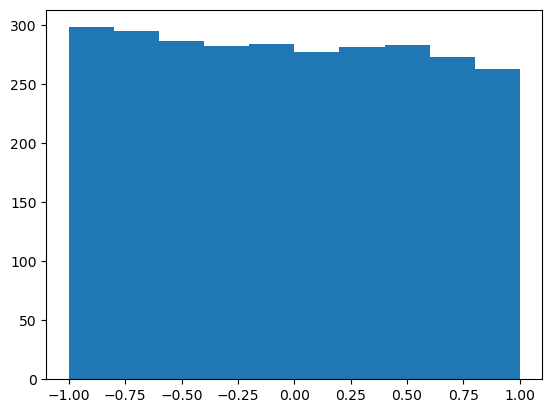

In [16]:
plt.figure()
plt.hist(p)